In [24]:
!pip install seqeval

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [25]:
import pandas as pd
import logging
import re
import json
import numpy as np
import torch
from tqdm import trange
from tqdm import tqdm_notebook as tqdm
from transformers import BertForTokenClassification, BertTokenizerFast
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import Adam
from seqeval.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [26]:
MAX_LEN = 500
EPOCHS = 6
MODEL_PATH = '../input/bert-base-uncased'
TOKENIZER = BertTokenizerFast('../input/bert-base-uncased/vocab.txt', lowercase=True)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [27]:
df = pd.read_json('../input/resume-entities-for-ner/Entity Recognition in Resumes.json', lines=True)

In [28]:
df.head()

,content,annotation,extras
0,Abhishek Jha\nApplication Development Associat...,"[{'label': ['Skills'], 'points': [{'start': 12...",NaN
1,Afreen Jamadar\nActive member of IIIT Committe...,"[{'label': ['Email Address'], 'points': [{'sta...",NaN
2,"Akhil Yadav Polemaina\nHyderabad, Telangana - ...","[{'label': ['Skills'], 'points': [{'start': 37...",NaN
3,Alok Khandai\nOperational Analyst (SQL DBA) En...,"[{'label': ['Skills'], 'points': [{'start': 80...",NaN
4,Ananya Chavan\nlecturer - oracle tutorials\n\n...,"[{'label': ['Degree'], 'points': [{'start': 20...",NaN


In [29]:
def convert_dataturks_to_spacy(dataturks_JSON_FilePath):
    try:
        training_data = []
        lines=[]
        with open(dataturks_JSON_FilePath, 'r') as f:
            lines = f.readlines()

        for line in lines:
            data = json.loads(line)
            text = data['content'].replace("\n", " ")
            entities = []
            data_annotations = data['annotation']
            if data_annotations is not None:
                for annotation in data_annotations:
                    #only a single point in text annotation.
                    point = annotation['points'][0]
                    labels = annotation['label']
                    # handle both list of labels or a single label.
                    if not isinstance(labels, list):
                        labels = [labels]

                    for label in labels:
                        point_start = point['start']
                        point_end = point['end']
                        point_text = point['text']
                        
                        lstrip_diff = len(point_text) - len(point_text.lstrip())
                        rstrip_diff = len(point_text) - len(point_text.rstrip())
                        if lstrip_diff != 0:
                            point_start = point_start + lstrip_diff
                        if rstrip_diff != 0:
                            point_end = point_end - rstrip_diff
                        entities.append((point_start, point_end + 1 , label))
            training_data.append((text, {"entities" : entities}))
        return training_data
    except Exception as e:
        logging.exception("Unable to process " + dataturks_JSON_FilePath + "\n" + "error = " + str(e))
        return None

def trim_entity_spans(data: list) -> list:
    """Removes leading and trailing white spaces from entity spans.

    Args:
        data (list): The data to be cleaned in spaCy JSON format.

    Returns:
        list: The cleaned data.
    """
    invalid_span_tokens = re.compile(r'\s')

    cleaned_data = []
    for text, annotations in data:
        entities = annotations['entities']
        valid_entities = []
        for start, end, label in entities:
            valid_start = start
            valid_end = end
            while valid_start < len(text) and invalid_span_tokens.match(
                    text[valid_start]):
                valid_start += 1
            while valid_end > 1 and invalid_span_tokens.match(
                    text[valid_end - 1]):
                valid_end -= 1
            valid_entities.append([valid_start, valid_end, label])
        cleaned_data.append([text, {'entities': valid_entities}])
    return cleaned_data

In [30]:
data = trim_entity_spans(convert_dataturks_to_spacy('../input/resume-entities-for-ner/Entity Recognition in Resumes.json'))

In [31]:
def get_label(offset, labels):
    if offset[0] == 0 and offset[1] == 0:
        return 'O'
    for label in labels:
        if offset[1] >= label[0] and offset[0] <= label[1]:
            return label[2]
    return 'O'

In [32]:
tags_vals = ["UNKNOWN", "O", "Name", "Degree","Skills","College Name","Email Address","Designation","Companies worked at","Graduation Year","Years of Experience","Location"]
tag2idx = {t: i for i, t in enumerate(tags_vals)}
idx2tag = {i:t for i, t in enumerate(tags_vals)}

In [33]:
def process_resume(data, tokenizer, tag2idx, max_len, is_test=False):
    tok = tokenizer.encode_plus(data[0], max_length=max_len, return_offsets_mapping=True)
    curr_sent = {'orig_labels':[], 'labels': []}
    
    padding_length = max_len - len(tok['input_ids'])
    
    if not is_test:
        labels = data[1]['entities']
        labels.reverse()
        for off in tok['offset_mapping']:
            label = get_label(off, labels)
            curr_sent['orig_labels'].append(label)
            curr_sent['labels'].append(tag2idx[label])
        curr_sent['labels'] = curr_sent['labels'] + ([0] * padding_length)
    
    curr_sent['input_ids'] = tok['input_ids'] + ([0] * padding_length)
    curr_sent['token_type_ids'] = tok['token_type_ids'] + ([0] * padding_length)
    curr_sent['attention_mask'] = tok['attention_mask'] + ([0] * padding_length)
    return curr_sent

In [34]:
class ResumeDataset(Dataset):
    def __init__(self, resume, tokenizer, tag2idx, max_len, is_test=False):
        self.resume = resume
        self.tokenizer = tokenizer
        self.is_test = is_test
        self.tag2idx = tag2idx
        self.max_len = max_len
    
    def __len__(self):
        return len(self.resume)
    
    def __getitem__(self, idx):
        data = process_resume(self.resume[idx], self.tokenizer, self.tag2idx, self.max_len, self.is_test)
        return {
            'input_ids': torch.tensor(data['input_ids'], dtype=torch.long),
            'token_type_ids': torch.tensor(data['token_type_ids'], dtype=torch.long),
            'attention_mask': torch.tensor(data['attention_mask'], dtype=torch.long),
            'labels': torch.tensor(data['labels'], dtype=torch.long),
            'orig_label': data['orig_labels']
        }

In [35]:
total = len(data)
train_data, val_data = data[:180], data[180:]

In [36]:
train_d = ResumeDataset(train_data, TOKENIZER, tag2idx, MAX_LEN)
val_d = ResumeDataset(val_data, TOKENIZER, tag2idx, MAX_LEN)

In [37]:
train_sampler = RandomSampler(train_d)
train_dl = DataLoader(train_d, sampler=train_sampler, batch_size=8)

val_dl = DataLoader(val_d, batch_size=4)

In [38]:
def get_hyperparameters(model, ff):

    # ff: full_finetuning
    if ff:
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "gamma", "beta"]
        optimizer_grouped_parameters = [
            {
                "params": [
                    p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
                ],
                "weight_decay_rate": 0.01,
            },
            {
                "params": [
                    p for n, p in param_optimizer if any(nd in n for nd in no_decay)
                ],
                "weight_decay_rate": 0.0,
            },
        ]
    else:
        param_optimizer = list(model.classifier.named_parameters())
        optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

    return optimizer_grouped_parameters

In [39]:
def get_special_tokens(tokenizer, tag2idx):
    vocab = tokenizer.get_vocab()
    pad_tok = vocab["[PAD]"]
    sep_tok = vocab["[SEP]"]
    cls_tok = vocab["[CLS]"]
    o_lab = tag2idx["O"]

    return pad_tok, sep_tok, cls_tok, o_lab

In [40]:
def annot_confusion_matrix(valid_tags, pred_tags):

    """
    Create an annotated confusion matrix by adding label
    annotations and formatting to sklearn's `confusion_matrix`.
    """

    # Create header from unique tags
    header = sorted(list(set(valid_tags + pred_tags)))

    # Calculate the actual confusion matrix
    matrix = confusion_matrix(valid_tags, pred_tags, labels=header)

    # Final formatting touches for the string output
    mat_formatted = [header[i] + "\t\t\t" + str(row) for i, row in enumerate(matrix)]
    content = "\t" + " ".join(header) + "\n" + "\n".join(mat_formatted)

    return content

In [41]:
def flat_accuracy(valid_tags, pred_tags):
    return (np.array(valid_tags) == np.array(pred_tags)).mean()

In [42]:
model = BertForTokenClassification.from_pretrained(MODEL_PATH, num_labels=len(tag2idx))
model.to(DEVICE);
optimizer_grouped_parameters = get_hyperparameters(model, True)
optimizer = Adam(optimizer_grouped_parameters, lr=2e-4)

In [43]:
MAX_GRAD_NORM = 1.0

In [44]:
def train_and_save_model(
    model,
    tokenizer,
    optimizer,
    epochs,
    idx2tag,
    tag2idx,
    max_grad_norm,
    device,
    train_dataloader,
    valid_dataloader
):

    pad_tok, sep_tok, cls_tok, o_lab = get_special_tokens(tokenizer, tag2idx)
    
    epoch = 0
    for _ in trange(epochs, desc="Epoch"):
        epoch += 1

        # Training loop
        print("Starting training loop.")
        model.train()
        tr_loss, tr_accuracy = 0, 0
        nb_tr_examples, nb_tr_steps = 0, 0
        tr_preds, tr_labels = [], []

        for step, batch in enumerate(train_dataloader):
            # Add batch to gpu
            
            # batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch['input_ids'], batch['attention_mask'], batch['labels']
            b_input_ids, b_input_mask, b_labels = b_input_ids.to(device), b_input_mask.to(device), b_labels.to(device)

            # Forward pass
            outputs = model(
                b_input_ids,
                token_type_ids=None,
                attention_mask=b_input_mask,
                labels=b_labels,
            )
            loss, tr_logits = outputs[:2]

            # Backward pass
            loss.backward()

            # Compute train loss
            tr_loss += loss.item()
            nb_tr_examples += b_input_ids.size(0)
            nb_tr_steps += 1

            # Subset out unwanted predictions on CLS/PAD/SEP tokens
            preds_mask = (
                (b_input_ids != cls_tok)
                & (b_input_ids != pad_tok)
                & (b_input_ids != sep_tok)
            )

            tr_logits = tr_logits.cpu().detach().numpy()
            tr_label_ids = torch.masked_select(b_labels, (preds_mask == 1))
            preds_mask = preds_mask.cpu().detach().numpy()
            tr_batch_preds = np.argmax(tr_logits[preds_mask.squeeze()], axis=1)
            tr_batch_labels = tr_label_ids.to("cpu").numpy()
            tr_preds.extend(tr_batch_preds)
            tr_labels.extend(tr_batch_labels)

            # Compute training accuracy
            tmp_tr_accuracy = flat_accuracy(tr_batch_labels, tr_batch_preds)
            tr_accuracy += tmp_tr_accuracy

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(
                parameters=model.parameters(), max_norm=max_grad_norm
            )

            # Update parameters
            optimizer.step()
            model.zero_grad()

        tr_loss = tr_loss / nb_tr_steps
        tr_accuracy = tr_accuracy / nb_tr_steps

        # Print training loss and accuracy per epoch
        print(f"Train loss: {tr_loss}")
        print(f"Train accuracy: {tr_accuracy}")
        
        
        """
        Validation loop
        """ 
        print("Starting validation loop.")

        model.eval()
        eval_loss, eval_accuracy = 0, 0
        nb_eval_steps, nb_eval_examples = 0, 0
        predictions, true_labels = [], []

        for batch in valid_dataloader:

            b_input_ids, b_input_mask, b_labels = batch['input_ids'], batch['attention_mask'], batch['labels']
            b_input_ids, b_input_mask, b_labels = b_input_ids.to(device), b_input_mask.to(device), b_labels.to(device)

            with torch.no_grad():
                outputs = model(
                    b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels=b_labels,
                )
                tmp_eval_loss, logits = outputs[:2]

            # Subset out unwanted predictions on CLS/PAD/SEP tokens
            preds_mask = (
                (b_input_ids != cls_tok)
                & (b_input_ids != pad_tok)
                & (b_input_ids != sep_tok)
            )

            logits = logits.cpu().detach().numpy()
            label_ids = torch.masked_select(b_labels, (preds_mask == 1))
            preds_mask = preds_mask.cpu().detach().numpy()
            val_batch_preds = np.argmax(logits[preds_mask.squeeze()], axis=1)
            val_batch_labels = label_ids.to("cpu").numpy()
            predictions.extend(val_batch_preds)
            true_labels.extend(val_batch_labels)

            tmp_eval_accuracy = flat_accuracy(val_batch_labels, val_batch_preds)

            eval_loss += tmp_eval_loss.mean().item()
            eval_accuracy += tmp_eval_accuracy

            nb_eval_examples += b_input_ids.size(0)
            nb_eval_steps += 1

        # Evaluate loss, acc, conf. matrix, and class. report on devset
        pred_tags = [idx2tag[i] for i in predictions]
        valid_tags = [idx2tag[i] for i in true_labels]
        #print(pred_tags)
        #print(valid_tags)
        cl_report = classification_report([valid_tags], [pred_tags])
        conf_mat = annot_confusion_matrix(valid_tags, pred_tags)
        eval_loss = eval_loss / nb_eval_steps
        eval_accuracy = eval_accuracy / nb_eval_steps

        # Report metrics
        print(f"Validation loss: {eval_loss}")
        print(f"Validation Accuracy: {eval_accuracy}")
        print(f"Classification Report:\n {cl_report}")
        print(f"Confusion Matrix:\n {conf_mat}")
        return tr_loss, tr_accuracy, eval_loss, eval_accuracy

In [55]:
learning_rate = [1e-4,2e-5,4e-5,6e-5,8e-5,1e-4,2e-4,4e-4,6e-4,8e-4,1e-3,2e-3,4e-3,6e-3,8e-3,1e-2,2e-2]

tr_loss  = []
tr_acc   = []
val_loss = []
val_acc  = []

optimizer = Adam(optimizer_grouped_parameters, lr=2e-4)

for lr in learning_rate:
    tl,ta,vl,va = train_and_save_model(
        model, 
        TOKENIZER, 
        optimizer, 
        EPOCHS, 
        idx2tag, 
        tag2idx, 
        MAX_GRAD_NORM, 
        DEVICE, 
        train_dl, 
        val_dl
    )
    tr_loss.append(tl)
    tr_acc.append(ta)
    val_loss.append(vl)
    val_acc.append(va)


Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Starting training loop.
Train loss: 0.03396287042161693
Train accuracy: 0.9894790718984031
Starting validation loop.


Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loss: 0.5708491504192352
Validation Accuracy: 0.8842098274884608
Classification Report:
                     precision    recall  f1-score   support

               ame       0.93      0.90      0.91        41
ears of Experience       0.12      0.20      0.15         5
             egree       0.51      0.69      0.59        35
        esignation       0.35      0.29      0.32        89
             kills       0.74      0.49      0.58       869
      mail Address       0.85      0.80      0.82      1130
           ocation       0.58      0.67      0.62        54
       ollege Name       0.23      0.55      0.32        33
ompanies worked at       0.18      0.37      0.24        59
    raduation Year       0.21      0.38      0.27        16

         micro avg       0.71      0.64      0.68      2331
         macro avg       0.47      0.53      0.48      2331
      weighted avg       0.75      0.64      0.68      2331

Confusion Matrix:
 	College Name Companies worked at Degr

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loss: 0.5855012714862824
Validation Accuracy: 0.8634784096526851
Classification Report:
                     precision    recall  f1-score   support

               ame       0.93      0.93      0.93        41
ears of Experience       0.25      0.40      0.31         5
             egree       0.54      0.57      0.56        35
        esignation       0.48      0.35      0.40        92
             kills       0.46      0.73      0.56       869
      mail Address       0.78      0.83      0.80      1130
           ocation       0.55      0.74      0.63        53
       ollege Name       0.20      0.33      0.25        33
ompanies worked at       0.21      0.37      0.26        60
    raduation Year       0.24      0.44      0.31        16

         micro avg       0.58      0.75      0.65      2334
         macro avg       0.46      0.57      0.50      2334
      weighted avg       0.61      0.75      0.67      2334

Confusion Matrix:
 	College Name Companies worked at Degr

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loss: 0.7977286398410797
Validation Accuracy: 0.8616855463861641
Classification Report:
                     precision    recall  f1-score   support

               ame       0.95      0.93      0.94        41
ears of Experience       0.25      0.20      0.22         5
             egree       0.47      0.63      0.54        35
        esignation       0.42      0.45      0.43        89
             kills       0.45      0.71      0.55       869
      mail Address       0.88      0.75      0.81      1130
           ocation       0.47      0.69      0.56        54
       ollege Name       0.20      0.48      0.28        33
ompanies worked at       0.33      0.37      0.35        59
    raduation Year       0.22      0.44      0.29        16

         micro avg       0.59      0.71      0.64      2331
         macro avg       0.46      0.56      0.50      2331
      weighted avg       0.66      0.71      0.67      2331

Confusion Matrix:
 	College Name Companies worked at Degr

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loss: 0.6568686842918396
Validation Accuracy: 0.8758279349473563
Classification Report:
                     precision    recall  f1-score   support

               ame       0.93      0.90      0.91        41
ears of Experience       0.17      0.20      0.18         5
             egree       0.61      0.71      0.66        35
        esignation       0.38      0.37      0.37        92
             kills       0.55      0.69      0.61       869
      mail Address       0.86      0.79      0.82      1130
           ocation       0.62      0.72      0.67        53
       ollege Name       0.27      0.55      0.36        33
ompanies worked at       0.20      0.35      0.25        60
    raduation Year       0.14      0.38      0.20        16

         micro avg       0.64      0.72      0.68      2334
         macro avg       0.47      0.57      0.50      2334
      weighted avg       0.68      0.72      0.69      2334

Confusion Matrix:
 	College Name Companies worked at Degr

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loss: 0.6167326360940933
Validation Accuracy: 0.878687762517677
Classification Report:
                     precision    recall  f1-score   support

               ame       0.93      0.90      0.91        41
ears of Experience       0.33      0.40      0.36         5
             egree       0.44      0.63      0.52        35
        esignation       0.38      0.47      0.42        89
             kills       0.56      0.68      0.62       869
      mail Address       0.83      0.83      0.83      1130
           ocation       0.64      0.70      0.67        54
       ollege Name       0.27      0.48      0.34        33
ompanies worked at       0.22      0.44      0.30        59
    raduation Year       0.21      0.50      0.30        16

         micro avg       0.65      0.74      0.69      2331
         macro avg       0.48      0.60      0.53      2331
      weighted avg       0.67      0.74      0.70      2331

Confusion Matrix:
 	College Name Companies worked at Degre

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loss: 0.867043960094452
Validation Accuracy: 0.8141225399936175
Classification Report:
                     precision    recall  f1-score   support

               ame       0.95      0.93      0.94        41
ears of Experience       0.22      0.40      0.29         5
             egree       0.48      0.63      0.54        35
        esignation       0.37      0.35      0.36        92
             kills       0.31      0.88      0.46       869
      mail Address       0.86      0.76      0.80      1130
           ocation       0.55      0.77      0.65        53
       ollege Name       0.23      0.45      0.30        33
ompanies worked at       0.17      0.33      0.23        60
    raduation Year       0.19      0.31      0.24        16

         micro avg       0.46      0.77      0.58      2334
         macro avg       0.43      0.58      0.48      2334
      weighted avg       0.59      0.77      0.63      2334

Confusion Matrix:
 	College Name Companies worked at Degre

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loss: 0.6381522953510285
Validation Accuracy: 0.8873666297187048
Classification Report:
                     precision    recall  f1-score   support

               ame       0.95      0.93      0.94        41
ears of Experience       0.33      0.40      0.36         5
             egree       0.62      0.66      0.64        35
        esignation       0.36      0.34      0.35        89
             kills       0.66      0.59      0.63       869
      mail Address       0.86      0.75      0.80      1130
           ocation       0.68      0.72      0.70        54
       ollege Name       0.28      0.58      0.37        33
ompanies worked at       0.23      0.36      0.28        59
    raduation Year       0.20      0.25      0.22        16

         micro avg       0.71      0.66      0.68      2331
         macro avg       0.52      0.56      0.53      2331
      weighted avg       0.73      0.66      0.69      2331

Confusion Matrix:
 	College Name Companies worked at Degr

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loss: 0.5879406929016113
Validation Accuracy: 0.8785023664284323
Classification Report:
                     precision    recall  f1-score   support

               ame       0.88      0.90      0.89        41
ears of Experience       0.20      0.20      0.20         5
             egree       0.62      0.69      0.65        35
        esignation       0.32      0.24      0.27        92
             kills       0.56      0.68      0.61       869
      mail Address       0.81      0.83      0.82      1130
           ocation       0.62      0.72      0.67        53
       ollege Name       0.31      0.45      0.37        33
ompanies worked at       0.25      0.33      0.28        60
    raduation Year       0.24      0.38      0.29        16

         micro avg       0.65      0.72      0.69      2334
         macro avg       0.48      0.54      0.51      2334
      weighted avg       0.66      0.72      0.69      2334

Confusion Matrix:
 	College Name Companies worked at Degr

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loss: 0.6476929396390915
Validation Accuracy: 0.8794214950800001
Classification Report:
                     precision    recall  f1-score   support

               ame       0.88      0.90      0.89        41
ears of Experience       0.22      0.40      0.29         5
             egree       0.47      0.63      0.54        35
        esignation       0.32      0.35      0.33        89
             kills       0.65      0.61      0.63       869
      mail Address       0.78      0.83      0.81      1130
           ocation       0.59      0.72      0.65        54
       ollege Name       0.26      0.52      0.34        33
ompanies worked at       0.14      0.39      0.20        59
    raduation Year       0.23      0.44      0.30        16

         micro avg       0.65      0.71      0.68      2331
         macro avg       0.45      0.58      0.50      2331
      weighted avg       0.68      0.71      0.69      2331

Confusion Matrix:
 	College Name Companies worked at Degr

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loss: 0.7017675280570984
Validation Accuracy: 0.8787455378930462
Classification Report:
                     precision    recall  f1-score   support

               ame       0.88      0.90      0.89        41
ears of Experience       0.22      0.40      0.29         5
             egree       0.40      0.66      0.50        35
        esignation       0.29      0.34      0.31        92
             kills       0.83      0.42      0.56       869
      mail Address       0.81      0.78      0.80      1130
           ocation       0.53      0.74      0.61        53
       ollege Name       0.30      0.58      0.40        33
ompanies worked at       0.14      0.37      0.20        60
    raduation Year       0.22      0.56      0.32        16

         micro avg       0.69      0.61      0.65      2334
         macro avg       0.46      0.57      0.49      2334
      weighted avg       0.76      0.61      0.66      2334

Confusion Matrix:
 	College Name Companies worked at Degr

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loss: 0.5783558666706086
Validation Accuracy: 0.8917005735607519
Classification Report:
                     precision    recall  f1-score   support

               ame       0.88      0.90      0.89        41
ears of Experience       0.00      0.00      0.00         5
             egree       0.51      0.57      0.54        35
        esignation       0.48      0.36      0.41        89
             kills       0.85      0.51      0.64       869
      mail Address       0.84      0.77      0.80      1130
           ocation       0.67      0.67      0.67        54
       ollege Name       0.26      0.52      0.35        33
ompanies worked at       0.21      0.39      0.27        59
    raduation Year       0.22      0.38      0.28        16

         micro avg       0.76      0.63      0.69      2331
         macro avg       0.49      0.51      0.48      2331
      weighted avg       0.79      0.63      0.69      2331

Confusion Matrix:
 	College Name Companies worked at Degr

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loss: 0.5245122715830803
Validation Accuracy: 0.8881331738661127
Classification Report:
                     precision    recall  f1-score   support

               ame       0.86      0.90      0.88        41
ears of Experience       0.00      0.00      0.00         5
             egree       0.50      0.49      0.49        35
        esignation       0.28      0.15      0.20        92
             kills       0.72      0.65      0.68       869
      mail Address       0.78      0.84      0.81      1130
           ocation       0.61      0.75      0.67        53
       ollege Name       0.30      0.61      0.40        33
ompanies worked at       0.19      0.28      0.23        60
    raduation Year       0.25      0.31      0.28        16

         micro avg       0.70      0.71      0.71      2334
         macro avg       0.45      0.50      0.46      2334
      weighted avg       0.70      0.71      0.71      2334

Confusion Matrix:
 	College Name Companies worked at Degr

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loss: 0.6514648169279098
Validation Accuracy: 0.866931267123158
Classification Report:
                     precision    recall  f1-score   support

               ame       0.91      0.95      0.93        41
ears of Experience       0.17      0.20      0.18         5
             egree       0.38      0.51      0.44        35
        esignation       0.47      0.39      0.43        89
             kills       0.59      0.68      0.63       869
      mail Address       0.65      0.85      0.74      1130
           ocation       0.54      0.70      0.61        54
       ollege Name       0.31      0.58      0.40        33
ompanies worked at       0.24      0.34      0.28        59
    raduation Year       0.21      0.31      0.25        16

         micro avg       0.60      0.74      0.66      2331
         macro avg       0.45      0.55      0.49      2331
      weighted avg       0.60      0.74      0.66      2331

Confusion Matrix:
 	College Name Companies worked at Degre

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loss: 0.7250181913375855
Validation Accuracy: 0.875110764228251
Classification Report:
                     precision    recall  f1-score   support

               ame       0.95      0.95      0.95        41
ears of Experience       0.20      0.20      0.20         5
             egree       0.59      0.69      0.63        35
        esignation       0.33      0.36      0.34        92
             kills       0.52      0.76      0.62       869
      mail Address       0.85      0.75      0.80      1130
           ocation       0.67      0.72      0.69        53
       ollege Name       0.24      0.30      0.27        33
ompanies worked at       0.25      0.45      0.33        60
    raduation Year       0.17      0.62      0.27        16

         micro avg       0.62      0.73      0.67      2334
         macro avg       0.48      0.58      0.51      2334
      weighted avg       0.67      0.73      0.69      2334

Confusion Matrix:
 	College Name Companies worked at Degre

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loss: 0.7181681483983994
Validation Accuracy: 0.85911518948874
Classification Report:
                     precision    recall  f1-score   support

               ame       0.95      0.98      0.96        41
ears of Experience       0.50      0.40      0.44         5
             egree       0.55      0.66      0.60        35
        esignation       0.33      0.45      0.38        89
             kills       0.47      0.74      0.57       869
      mail Address       0.73      0.84      0.78      1130
           ocation       0.60      0.78      0.68        54
       ollege Name       0.25      0.48      0.33        33
ompanies worked at       0.25      0.41      0.31        59
    raduation Year       0.00      0.00      0.00        16

         micro avg       0.57      0.76      0.65      2331
         macro avg       0.46      0.57      0.51      2331
      weighted avg       0.59      0.76      0.66      2331

Confusion Matrix:
 	College Name Companies worked at Degree

Epoch:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loss: 0.6330213218927383
Validation Accuracy: 0.880513160989295
Classification Report:
                     precision    recall  f1-score   support

               ame       0.90      0.93      0.92        41
ears of Experience       0.12      0.20      0.15         5
             egree       0.58      0.63      0.60        35
        esignation       0.42      0.36      0.39        92
             kills       0.59      0.69      0.64       869
      mail Address       0.82      0.81      0.81      1130
           ocation       0.58      0.75      0.66        53
       ollege Name       0.24      0.39      0.30        33
ompanies worked at       0.17      0.38      0.24        60
    raduation Year       0.23      0.50      0.31        16

         micro avg       0.65      0.72      0.69      2334
         macro avg       0.47      0.56      0.50      2334
      weighted avg       0.68      0.72      0.70      2334

Confusion Matrix:
 	College Name Companies worked at Degre

Epoch:   0%|          | 0/6 [00:11<?, ?it/s]

Validation loss: 0.6041965335607529
Validation Accuracy: 0.8874981006868261
Classification Report:
                     precision    recall  f1-score   support

               ame       0.98      0.98      0.98        41
ears of Experience       0.33      0.20      0.25         5
             egree       0.45      0.57      0.51        35
        esignation       0.40      0.37      0.39        89
             kills       0.68      0.63      0.65       869
      mail Address       0.81      0.83      0.82      1130
           ocation       0.62      0.78      0.69        54
       ollege Name       0.30      0.55      0.39        33
ompanies worked at       0.16      0.41      0.23        59
    raduation Year       0.31      0.50      0.38        16

         micro avg       0.69      0.72      0.70      2331
         macro avg       0.50      0.58      0.53      2331
      weighted avg       0.71      0.72      0.71      2331

Confusion Matrix:
 	College Name Companies worked at Degr

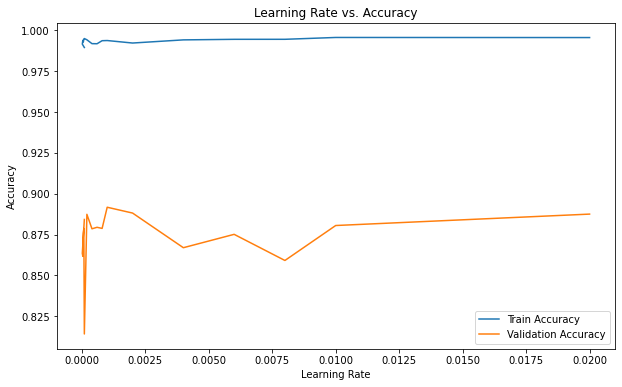

In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(learning_rate, tr_acc, label = "Train Accuracy")
plt.plot(learning_rate, val_acc, label = "Validation Accuracy")

plt.title("Learning Rate vs. Accuracy")
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

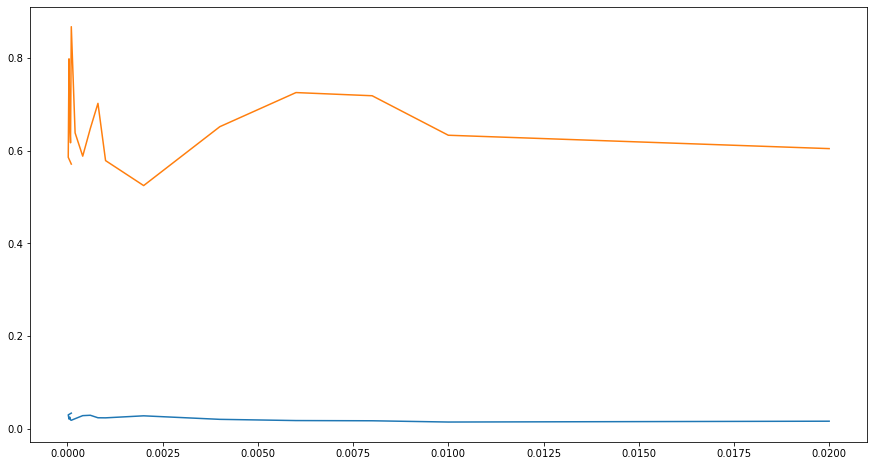

In [58]:
plt.figure(figsize=(15, 8))

plt.plot(learning_rate, tr_loss, label = "Train Loss")
plt.plot(learning_rate, val_loss, label = "Validation Loss")

In [ ]:
torch.save(
    {
        "epoch": EPOCHS,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
    },
    'model_e6.tar',
)